# Train Model



## Set parameters that will control the execution

In [1]:
data_dir = "../_DATA/CarND/p3_behavioral_cloning/set_000/"
image_dir = "IMG/"
driving_data_csv = "driving_log_original.csv"
YIELD_BATCH_SIZE = 32 #256
RUN_EPOCHS = 3 

should_retrain_existing_model = False
saved_model = "model_epoch_33_val_acc_0.0.h5"
previous_trained_epochs = 0

In [2]:
import DataHelper

Using TensorFlow backend.


# Allocate only a fraction of memory to TensorFlow GPU process

In [3]:
# https://github.com/aymericdamien/TensorFlow-Examples/issues/38#issuecomment-265599695
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9) # try range from 0.3 to 0.9
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True, gpu_options=gpu_options))

#### Show available CPU and GPU(s)
from tensorflow.python.client import device_lib
def get_available_CPU_GPU():
    devices = device_lib.list_local_devices()
    #return [x.name for x in devices if x.device_type == 'CPU']
    return [x.name for x in devices ]

print(get_available_CPU_GPU())

['/cpu:0', '/gpu:0']


# Fetch data from CSV file

In [4]:
from  DataHelper import read_csv
csv_path = data_dir + driving_data_csv
print("csv_path", csv_path)
headers, data = read_csv(data_dir + driving_data_csv)

csv_path ../_DATA/CarND/p3_behavioral_cloning/set_000/driving_log_original.csv
Number of imported CSV rows: 8037


# Split data into training, testing and validation sets

In [5]:
from DataHelper import split_random
training, testing, validation = split_random(data, percent_train=75, percent_test=15) 

print("training", training.shape, type(training) )
print("testing", testing.shape)
print("validation", validation.shape)

percent_validation 10
training (6027, 7) <class 'numpy.ndarray'>
testing (1206, 7)
validation (803, 7)


# Fetch and visualize training steering angles

I would like to train a car on the set that has a nice bell curve distribution of values:
- I can drive the car on the track backwards
- I can flip each image (and value)

# Remove zero-steering angles from training set 

In [6]:
import numpy as np
from DataHelper import plot_histogram, get_steering_values, find_nearest

len(training) 6027
min_value -0.942695 max_value 1.0
spread 1.9427 in 195 bins


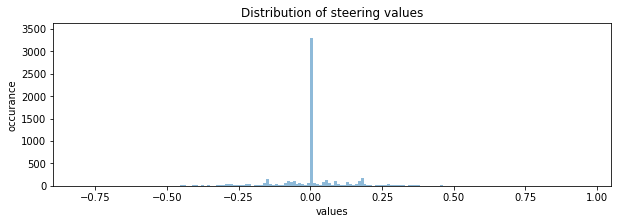

len(indexes_to_keep) 2732
len(training) 2732
min_value -0.942695 max_value 1.0
spread 1.9427 in 195 bins


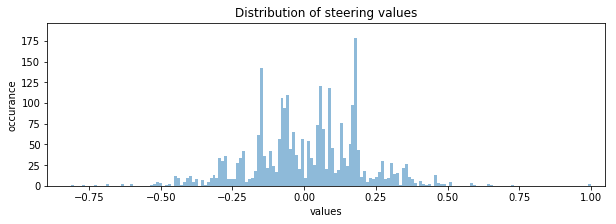

In [7]:
def remove_zeros(training):
    
    print("len(training)", len(training))
    indexes_to_keep = []
    
    steering_angles = get_steering_values(training)
    plot_histogram("steering values", steering_angles, change_step=0.01)

    for index in range (len(steering_angles)):
        angle = steering_angles[index]
        if angle != 0: 
            indexes_to_keep.append(index)

    print("len(indexes_to_keep)", len(indexes_to_keep))

    training_to_keep = []
    for index in indexes_to_keep:
        training_to_keep.append(training[index])

    training = training_to_keep
    # release the memory
    training_to_keep = []
    indexes_to_keep = []

    print("len(training)", len(training))

    steering_angles = get_steering_values(training)
    plot_histogram("steering values", steering_angles, change_step=0.01)
    return training

training = remove_zeros(training)

# Extract image names

In [8]:
def get_center_image_names(training):
    from DataHelper import get_image_center_values 
    image_names = get_image_center_values(training)
    print("image count", image_names.shape[0])
    print(image_names[1])
    return image_names

image_names = get_center_image_names(training)

image count 2732
IMG/center_2016_12_01_13_43_47_713.jpg


# Create a list of image paths

In [9]:
def build_image_paths(image_names):
    image_paths = []
    for image_name in image_names:
        image_paths.extend([data_dir + image_name])
    print(image_paths[1]) 
    print("found paths:", len(image_paths) ) 
    return image_paths

image_paths = build_image_paths(image_names)

../_DATA/CarND/p3_behavioral_cloning/set_000/IMG/center_2016_12_01_13_43_47_713.jpg
found paths: 2732


# Read actual images

In [10]:
def read_images(image_paths):
    import numpy as np 
    from ImageHelper import read_image_array
    #training_features = [read_image_array(path) for path in image_paths]

    image_list = []
    for path in image_paths[0:5]:
        image_list.append(read_image_array(path))
    training_features = np.array(image_list) # numpy array, not just a list
    return training_features

image_paths[2] ../_DATA/CarND/p3_behavioral_cloning/set_000/IMG/center_2016_12_01_13_38_50_311.jpg
training_features count 5
sample_image   (160, 320, 3)


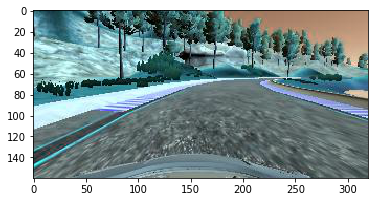

In [11]:
training_features = read_images(image_paths)

print ("image_paths[2]", image_paths[2] )
print ("training_features count", len(training_features) )

sample_image = training_features[2]
print ("sample_image  ", sample_image.shape)

import matplotlib.pyplot as plt
plt.imshow(sample_image) # cmap='gray' , cmap='rainbow'
plt.show()

#print(sample_image[0][0:15])

# Define yield Generator

In [12]:
import numpy as np

def generator(training: np.ndarray, batch_size: int=32):
    """
    Yields batches of training and testing data every time the generator is called.
    I will use Keras to pre-process images (trim, resize)
    """
    import sklearn
    
    while True:
        #shuffle(training) # unnecessary and probably a bad idea
        for offset in range(0, len(training), batch_size):
            training_batch = training[offset:(offset + batch_size)]
            
            steering_angles = get_steering_values(training_batch)
            
            image_names = get_center_image_names(training_batch)
            image_paths = build_image_paths(image_names)
            training_features = read_images(image_paths)

            # I will use Keras to pre-process images (trim, resize)
            
            X_train = np.array(training_features)
            y_train = np.array(steering_angles)
            
            # it is OK to shuffle records within the batch
            # may be not desirable if we want to learn from sequence of images in the future
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(training, YIELD_BATCH_SIZE)
validation_generator = generator(testing, YIELD_BATCH_SIZE)

# Import Keras (layer above TensorFlow)

https://keras.io/layers/convolutional/

In [13]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import ELU, InputLayer, Input
from keras.layers.core import Flatten, Dense, Dropout, Activation, Lambda
from keras.activations import relu, softmax
from keras.optimizers import SGD
import cv2, numpy as np
from DataHelper import mean_pred, false_rates
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Convolution1D

# Build a Convolutional Neural Network

## Minimal Model

In [14]:
# image_dimentions = (3, 80, 320)  # Trimmed image format

In [15]:
def get_CDNN_model_minimal(input_shape):
    model = Sequential()
    
    model.add(Lambda(lambda x: x/255.0 - 0.5, # normalize RGB 0-255 to -0.5 to 0.5
                     input_shape=input_shape,
                    name="Normalize_RGB"))
    model.add(Convolution2D(32, 3, 3, border_mode='same', 
                            activation="relu", dim_ordering='tf', name="Convo_ReLU_32x3x3_01"))
    model.add(Convolution2D(32, 5, 5, border_mode='same', 
                            activation="relu", name="Convo_ReLU_32x5x5_02" ))
    model.add(Convolution2D(32, 5, 5, border_mode='same', 
                            activation="relu", name="Convo_ReLU_32x5x5_03" ))
    model.add(Flatten())
    #model.add(MaxPooling2D(pool_size=(2, 2), name="MaxPool_2x2"))

    model.add(Dense(256, activation="relu", name="Dense_relu_256_01")) #256
    model.add(Dropout(0.25, name="Dropout_0.25_01"))
    model.add(Dense(256, activation="relu", name="Dense_relu_256_02" )) #256

    # CLASSIFICATION
    #model.add(Dense(41, activation='linear' , name="dense_3_41_linear")) # default: linear | softmax | relu | sigmoid

    # REGRESSION
    model.add(Dense(1, activation='linear'))
    return model

# Compile model (configure learning process)

In [16]:
input_shape = (160, 320, 3) # sample_image   (160, 320, 3)
model = get_CDNN_model_minimal(input_shape)
model.summary()
# Before training a model, you need to configure the learning process, which is done via the compile method.
# 
# keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

optimizer="adam" # 'sgd' | 'rmsprop'
loss_function="mse" # | 'binary_crossentropy' | 'mse' | mean_squared_error | sparse_categorical_crossentropy
metrics_array=['accuracy'] # , mean_pred, false_rates

model.compile(optimizer, loss_function, metrics_array)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Normalize_RGB (Lambda)           (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
Convo_ReLU_32x3x3_01 (Convolutio (None, 160, 320, 32)  896         Normalize_RGB[0][0]              
____________________________________________________________________________________________________
Convo_ReLU_32x5x5_02 (Convolutio (None, 160, 320, 32)  25632       Convo_ReLU_32x3x3_01[0][0]       
____________________________________________________________________________________________________
Convo_ReLU_32x5x5_03 (Convolutio (None, 160, 320, 32)  25632       Convo_ReLU_32x5x5_02[0][0]       
___________________________________________________________________________________________

# Replace model with one stored on disk

- If you replace the model, the INPUT dimetions have to be the same as these trained
- Name your models well

# Train (fit) the model agaist given labels

In [17]:
print( "training_features.shape", len(training_features) )

# https://keras.io/models/sequential/
# steps_per_epoch: 
# Total number of steps (batches of samples) to yield from generator before declaring one epoch finished 
# and starting the next epoch. 
# It should typically be equal to the number of unique samples 
# if your dataset divided by the batch size.
history = model.fit_generator(train_generator, 
                              samples_per_epoch = len(training), 
                              validation_data = validation_generator, 
                              nb_val_samples = len(validation), 
                              nb_epoch = RUN_EPOCHS)

training_features.shape 5
Epoch 1/3
image count 32
IMG/center_2016_12_01_13_43_47_713.jpg
../_DATA/CarND/p3_behavioral_cloning/set_000/IMG/center_2016_12_01_13_43_47_713.jpg
found paths: 32


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/keras/engine/training.py", line 429, in data_generator_task
    generator_output = next(self._generator)
  File "<ipython-input-12-d8e65fc344ee>", line 28, in generator
    yield sklearn.utils.shuffle(X_train, y_train)
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/sklearn/utils/__init__.py", line 285, in shuffle
    return resample(*arrays, **options)
  File "/Users/ukilucas/anaconda3/envs/py352_tf_gpu/lib/python3.5/site-packages/sklearn/utils/__init__.py", line 204, in resample
    check_consistent_length(*arrays)
  File "/Users/ukilucas/anacon

ValueError: output of generator should be a tuple (x, y, sample_weight) or (x, y). Found: None

In [ ]:
# list all data in history
print(history.history.keys())

training_accuracy = str( history.history['acc'][nb_epoch-1])
print("training_accuracy", training_accuracy)

training_error = str( history.history['loss'][nb_epoch-1])
print("training_error", training_error)

validation_accuracy = str( history.history['val_acc'][nb_epoch-1])
print("validation_accuracy", validation_accuracy)

validation_error = str( history.history['val_loss'][nb_epoch-1])
print("validation_error", validation_error)

# Save the model

In [ ]:
# creates a HDF5 file '___.h5'
model.save(data_dir 
           + "model_epoch_" + str(nb_epoch + previous_trained_epochs) 
           + "_val_acc_" + str(validation_accuracy) 
           + ".h5") 
#del model  # deletes the existing model
#model = load_model('my_model.h5')

# summarize history for accuracy

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy (bigger better)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'testing accuracy'], loc='lower right')
plt.show()



# summarize history for loss

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Validation error (smaller better)')
plt.ylabel('error')
plt.xlabel('epochs run')
plt.legend(['training error(loss)', 'validation error (loss)'], loc='upper right')
plt.show()

# Prediction

In [ ]:
from keras.models import load_model

model_path = data_dir + saved_model
print(model_path)

model = load_model(model_path) 
model.summary()

In [ ]:
image_name = "center_2016_12_01_13_38_59_461.jpg" # stering 0.05219137
original_steering_angle = 0.7315571

image_path =  data_dir +   image_name
print(image_path)
image = read_image(image_path)
print(image.shape)
plt.imshow(image, cmap='gray')
plt.show()

## Run model.predict(image)

In [ ]:
predictions = model.predict( image[None, :, :], 
                            batch_size = 1, 
                            verbose = 1)

# Extract top prediction

In [ ]:
from DataHelper import predict_class

predicted_class = predict_class(predictions, steering_classes)

print("original steering angle \n", original_steering_angle)
print("top_prediction \n", predicted_class )

# Plot predictions (peaks are top classes)

In [ ]:
# summarize history for loss
plt.plot(predictions[0])
plt.title('predictions')
plt.ylabel('y')
plt.xlabel('x')
plt.legend(['predictions'], loc='upper right')
plt.show()